# Week 4 - Probability Distributions 3 and Mixture Models

Learning contents:

1. Histogram-based density estimation
    - Display histogram densities
2. Kernel density estimation
    - Hypercube Kernel function
    - Gaussian Kernel function
3. K-Nearest Neigbours classification
    - Generate data
    - Classification function
    - Display results
4. K-Means clustering
    - Display results

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt
from collections import Counter
from scipy.stats import norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate data

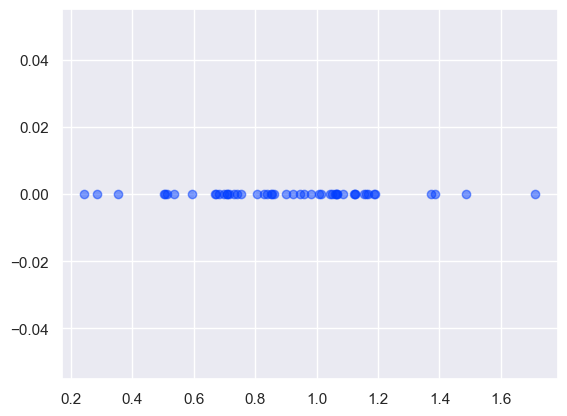

In [2]:
def generate_data_1D(size, means, variances, pis):
    result = 0
    
    for i, (mean, variance, pi) in enumerate(zip(means, variances, pis)):
        result += pi * np.array(norm(mean, sqrt(variance)).rvs(size=size, random_state=26 + i))
    
    return result
    
means = [0.4, 2.0]
variances = [0.2, 0.1]
pis = [0.7, 0.3]
data_1D = generate_data_1D(50, means, variances, pis)

plt.scatter(data_1D, [0] * len(data_1D), alpha=0.5)

## 1) Histogram-based density estimation

`histogram` takes `data`, bin size `delta` and returns `bins` (list of bins where `bin = list of points`) and their `probabilities`

In [3]:
def histogram(data, delta):
    data = sorted(data)
    
    bins = [[]]
    last_bin_position = data[0]
    
    for x in data:
        
        while (abs(x - last_bin_position) > delta):
            last_bin_position += delta
            bins.append([])

        bins[-1].append(x)
        
    probabilities = list(map(
        lambda b: len(b) / (delta * len(data)),
        bins
    ))
    
    return bins, probabilities

### 1.1) Display histogram densities

In [4]:
def display_histogram_density(data, delta):
    bins, probabilities = histogram(data, delta)

    plt.bar(range(len(bins)), list(map(lambda b: len(b), bins)))
    plt.plot(range(len(probabilities)), probabilities, '-r')


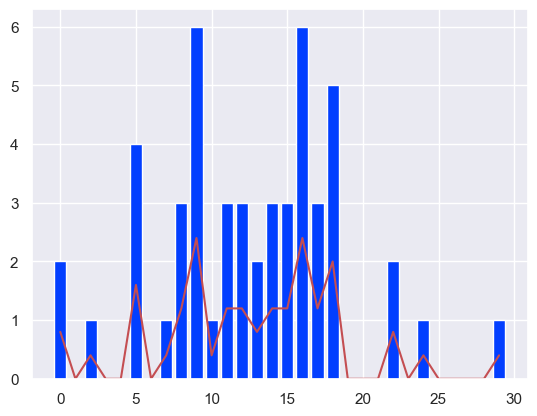

In [5]:
display_histogram_density(data_1D, 0.05)

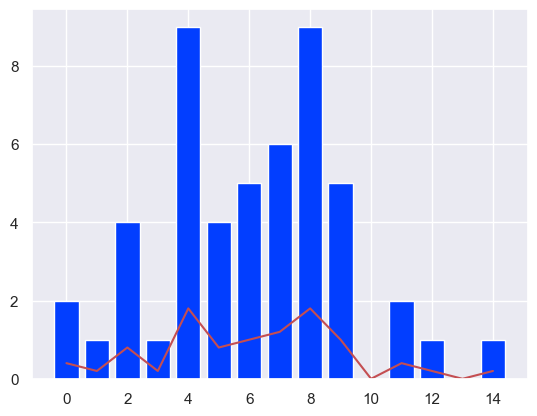

In [6]:
display_histogram_density(data_1D, 0.1)

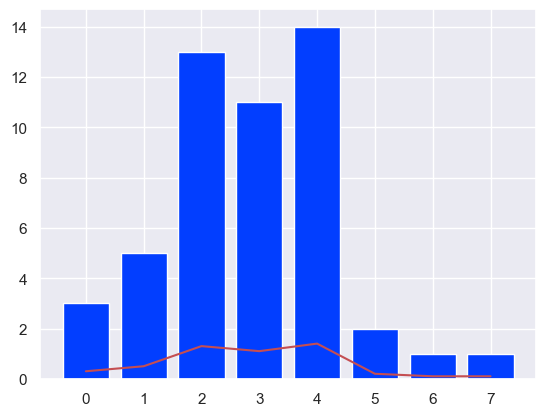

In [7]:
display_histogram_density(data_1D, 0.2)

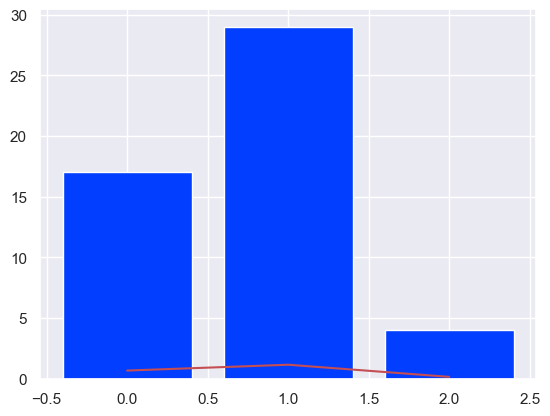

In [8]:
display_histogram_density(data_1D, 0.5)

## 2) Kernel density estimation

### 2.1) Hypercube Kernel function

`hypercube_kernel_function` takes `u` and returns 0 or 1 if `u` is inside 1/2 hypercube

In [9]:
def hypercube_kernel_function(u):
    return 1 if all(abs(u) <= 1/2) else 0

`hypercube_kernel_density` takes any point `x`, data points `data`, size of a cube `h`, amount of dimensions `D` and returns probability density function based on Hypercube kernel function

In [10]:
def hypercube_kernel_density(x, data, h, D):
    
    result = 0
    
    for x_n in data:
        result += hypercube_kernel_function(((x - x_n) / h).reshape(-1))
    
    result /= len(data) * (h ** D)
    return result

In [11]:
def display_hypercube_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: hypercube_kernel_density(x, data, h, 1), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

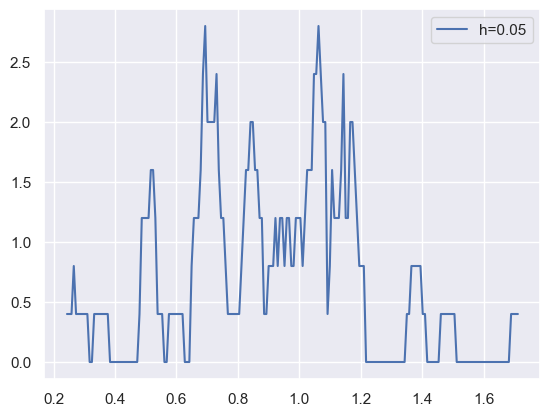

In [12]:
display_hypercube_kernel_density_1D(data_1D, 0.05, 'b')

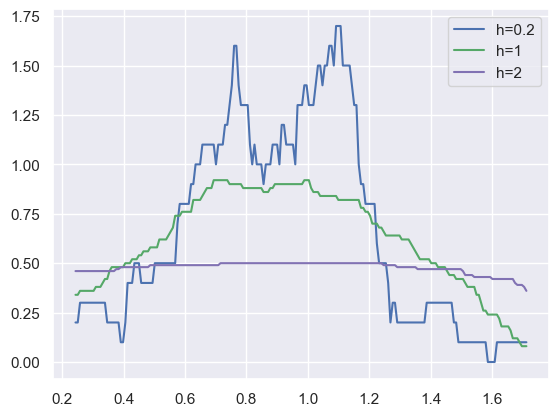

In [13]:
display_hypercube_kernel_density_1D(data_1D, 0.2, 'b')
display_hypercube_kernel_density_1D(data_1D, 1, 'g')
display_hypercube_kernel_density_1D(data_1D, 2, 'm')

### 2.2) Gaussian Kernel function

`gaussian_kernel_function` takes pair of points `x` and `x_n`, size `h` and returns Gaussian kernel function for this pair of points

In [14]:
def gaussian_kernel_function(x, x_n, h):
    return norm.pdf(0, sqrt(np.dot(x - x_n, x - x_n)), h)

`gaussian_kernel_density` takes any point `x`, data points `data`, size `h` and returns Gaussian kernel density for point `x`

In [15]:
def gaussian_kernel_density(x, data, h):
    
    result = 0
    
    for x_n in data:
        result += gaussian_kernel_function(x.reshape(-1), x_n.reshape(-1), h)
    
    result /= len(data)
    return result

In [16]:
def display_gaussian_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: gaussian_kernel_density(x, data, h), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

In [ ]:
display_gaussian_kernel_density_1D(data_1D, 0.01, 'b')
display_gaussian_kernel_density_1D(data_1D, 0.05, 'g')
display_gaussian_kernel_density_1D(data_1D, 0.2, 'r')

## 3) K-Nearest Neigbours classification

### 3.1) Generate Data

In [ ]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

### 3.2) Classification function

`k_nearest_classification` takes any point `x`, data point positions `data_x`, their classes `data_t`, amount of neighbours `k` and returns class for the point `x`

In [ ]:
def k_nearest_classification(x, data_x, data_t, k):
    grouped_points = zip(data_x, data_t)
    k_nearest = sorted(grouped_points, key=lambda d: np.dot(x-d[0], x-d[0]))[:k]
    k_nearest_classes = list(map(lambda a: a[1], k_nearest))
    
    counter = Counter(k_nearest_classes)
    return counter.most_common()[0][0]

### 3.3) Display results

In [ ]:
def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

In [ ]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 1))
plt.legend([], loc="upper left", title="K=1")

In [ ]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 4))
plt.legend([], loc="upper left", title="K=4")

In [ ]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 8))
plt.legend([], loc="upper left", title="K=8")

## 4) K-Means clustering

`k_means_step` takes initial means `mus_0`, data points `data_x` and returns new means `mus` and `classes`

In [ ]:
def k_means_step(mus_0, data_x):
    
    
    def set_class(x):
        distance = list(map(
            lambda mu: np.dot(np.array(mu) - np.array(x), np.array(mu) - np.array(x)),
            mus_0
        ))
        
        return np.argmin(distance)
        
    
    
    classes = list(map(
        set_class, data_x
    ))
    
    mus = np.zeros([len(mus_0), len(data_x[0])])
    counts = np.zeros([len(mus), 1])
    
    for i, c in enumerate(classes):
        mus[c] += data_x[i]
        counts[c] += 1
    
    mus /= counts
    
    return mus, classes

`distortion_measure` takes means `mus`, `classes`, data points `data_x` and returns distortion of this classification

In [ ]:
def distortion_measure(mus, classes, data_x):
    
    result = 0
    
    for i, c in enumerate(classes):
        
        x = data_x[i]
        mu = mus[c]
        distance = np.dot(np.array(mu) - np.array(x), np.array(mu) - np.array(x))
        result += distance
    
    return result

`optimize_k_means` takes initial means `mus_0`, data points `data_x` and callback `on_step`

`on_step` is a function that takes current `mus` and `classes` and should be called each step 

In [ ]:
def optimize_k_means(mus_0, data_x, on_step):
    
    last_classes = None
    classes = []
    mus = mus_0
    
    while classes != last_classes:
        
        last_classes = classes
        mus, classes = k_means_step(mus, data_x)
        
        on_step(mus, classes)

### 4.1) Display results

In [ ]:
def plot_k_means(mus, classes, target=plt):
    plot = plot_iris(classes=classes, target=target)
    scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='X', s=300, edgecolors='black')
    return (*plot, scatter)

In [ ]:
k = 3
mus_0 = iris_x[:k]

all_steps = []

optimize_k_means(mus_0, iris_x, lambda mus, classes: all_steps.append((mus, classes)))

In [ ]:
def create_animation(all_steps, data_x):
    
    distortions = list(map(
        lambda a: distortion_measure(a[0], a[1], data_x),
        all_steps
    ))
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        plot1 = plot_k_means(all_steps[i][0], all_steps[i][1], target=ax)
        ax2.plot(list(range(i)), distortions[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Distortion')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps, iris_x)